# Utility experiments

Execute experiments for agents and agreement. The experiments cover different combination of parameters and behaviour of agents.

In [1]:
from simulation.agent import Agent
from simulation.registry import Registry
from simulation.agreement import Agreement

## Parameters
Layers consists of a lower and upper bound, and a deposit factor.

In [21]:
layers =  [
    {},
    {'lower': 0, 'upper': 20, 'factor': 2},
    {'lower': 20, 'upper': 40, 'factor': 1.75},
    {'lower': 40, 'upper': 60, 'factor': 1.5},
    {'lower': 60, 'upper': 80, 'factor': 1.25}
]
actions = [100,0]

num_agents_performing = 1000
num_agents_receiving = 1000
agents_performing = []
agents_receiving = []

num_agents = num_agents_performing + num_agents_receiving

for i in range(num_agents):
    if i < num_agents_performing:
        agents_performing.append(Agent(i,agent_type='rational'))
    else:
        agents_receiving.append(Agent(i,agent_type='rational'))

a1obj = {
    'payment': 2,
    'cost_perform': 1,
    'cost_receive': 0.1,
    'deposit': 10,
    'interest': 0.05,
    'valuation_perform': 12,
    'valuation_receive': 15
}
a1 = Agreement(a1obj)

## Experiments
The performing agents are executing actions. This affects the utility of the receiving and performing agents. We report the average utility of agents.

In [22]:
rounds = 10

registry = Registry(layers=layers, num_agents=num_agents, actions=actions)

for agent in agents_performing:
    agent.register_agreement(a1.payment, a1.cost_perform, a1.deposit, a1.interest, a1.valuation_perform)
    registry.register(agent.id)
    agent.set_factor(registry.layers[1]['factor'])

for agent in agents_receiving:
    agent.register_agreement(a1.payment, a1.cost_receive, a1.deposit, a1.interest, a1.valuation_receive)
    registry.register(agent.id)
    agent.set_factor(registry.layers[1]['factor'])

sum_utility_perform_rational = [0] * rounds
sum_utility_receiving = [0] * rounds
sum_utility = [0] * rounds
desired_actions = [0] * rounds
undesired_actions = [0] * rounds
no_actions = [0] * rounds

layer_count = []
for i in range(len(layers)):
    layer_count.append([0] * rounds)

for r in range(rounds):
    for i in range(len(agents_performing)):
        # get the agent layer
        this_layer = registry.agent_layer[i]
        layer_count[this_layer][r] += 1
        
        if this_layer is not 0:
            # get the latest factor
            agents_performing[i].factor = registry.get_factor(i)
            agents_receiving[i].factor = agents_performing[i].factor 

            # let all performing agents perform an action
            action, utility_perform = agents_performing[i].perform_action(0)
            agents_performing[i].update_utility(utility_perform)


            # update the registry with the actions
            if action == 'desired':
                registry.update(i, 0)
                desired_actions[r] += 1
            elif action == 'undesired':
                registry.update(i, 1)
                undesired_actions[r] += 1
            elif action == 'no_action':
                utility = 0 - cost
                no_actions[r] += 1

            # receiving agents update their utility based on the action of the performing agent
            utility_receive = agents_receiving[i].utility_receiving(0, action)
            agents_receiving[i].update_utility(utility_receive)
        else:
            utility_perform = 0
            utility_receive = 0
            
        sum_utility_perform_rational[r] += utility_perform
        sum_utility_receiving[r] += utility_receive
    
    # after every round curate the registry
    registry.curate()

## Visualise results

In [23]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Disitribution of actions

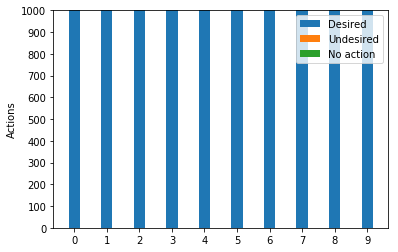

In [24]:
ind = np.arange(rounds)
width = 0.35

p1 = plt.bar(ind, desired_actions, width)
p2 = plt.bar(ind, undesired_actions, width,
             bottom=desired_actions)
p3 = plt.bar(ind, no_actions, width,
             bottom=undesired_actions)

plt.ylabel('Actions')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 1100, 100))
plt.legend((p1[0], p2[0], p3[0]), ('Desired', 'Undesired', 'No action'))

plt.show()


### Distribution of agents in layers

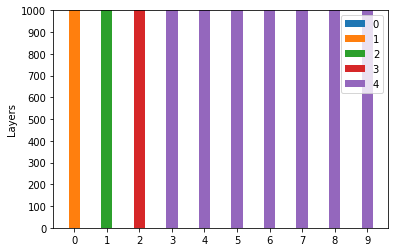

In [25]:
ind = np.arange(rounds)
width = 0.35

ps = dict()

for i in range(len(layers)):
    if i == 0:
        ps[i] = plt.bar(ind, layer_count[i], width)
    else:
        ps[i] = plt.bar(ind, layer_count[i], width,
             bottom=layer_count[i-1])

plt.ylabel('Layers')
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 1100, 100))
plt.legend(ps)

plt.show()